In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yt
from matplotlib.ticker import ScalarFormatter

from gallifrey.analysis import count_planets
from gallifrey.model import Model
from gallifrey.utilities.dataframe import rename_labels
from gallifrey.utilities.math import calculate_pca
from gallifrey.visualization.visualization_utils import (
    FigureProcessor,
    adjust_legend,
    get_palette,
    ridgeplot,
    set_plot_defaults,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 8192
sim_id = "37_11"
num_embryos = 50
host_star_masses = 1
planet_categories = [
    "Earth",
    "Super-Earth",
    "Neptunian",
    "Sub-Giant",
    "Giant",
]

In [5]:
model = Model(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)
ds = model.ds
mw = model.halo

yt : [INFO     ] 2023-11-24 09:53:44,425 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-11-24 09:53:44,577 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-11-24 09:53:44,578 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-24 09:53:44,579 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-24 09:53:44,581 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-11-24 09:53:44,582 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-24 09:53:44,583 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-11-24 09:53:44,584 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-11-24 09:53:44,585 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-11-24 09:53:44,586 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-11-24 09:53:44,588 Parameters: hubble_constant      

## PLOT SETUP

In [6]:
set_plot_defaults()

figure_subdirectory = f"MilkyWayAnalogue/{model.resolution}/{model.sim_id}/{model.snapshot}/Component_populations"
save = True

## CREATE DATASOURCE

In [7]:
radius = 0.2 * mw.virial_radius()
masses = (0.1, 0.5, 1)

## OCCURENCE RATES PER COMPONENT

In [8]:
occurence_rate_long_format = {}
for m in masses:
    occurence_rate_long_format[m] = count_planets(
        model,
        lambda: mw.sphere(radius=radius),
        planet_categories,
        normalize_by="planet_hosting_number",
        model_config={"ngpps_star_masses": m},
        long_format=True,
        value_name="Occurence Rate",
    )


      CONFIG: Setting ngpps_star_masses to 0.1.


      TIMER: Block 'Adding Planets...' took 3.42 seconds.


      CONFIG: Setting ngpps_star_masses to 0.5.


      TIMER: Block 'Adding Planets...' took 3.43 seconds.


      CONFIG: Setting ngpps_star_masses to 1.


      TIMER: Block 'Adding Planets...' took 3.22 seconds.



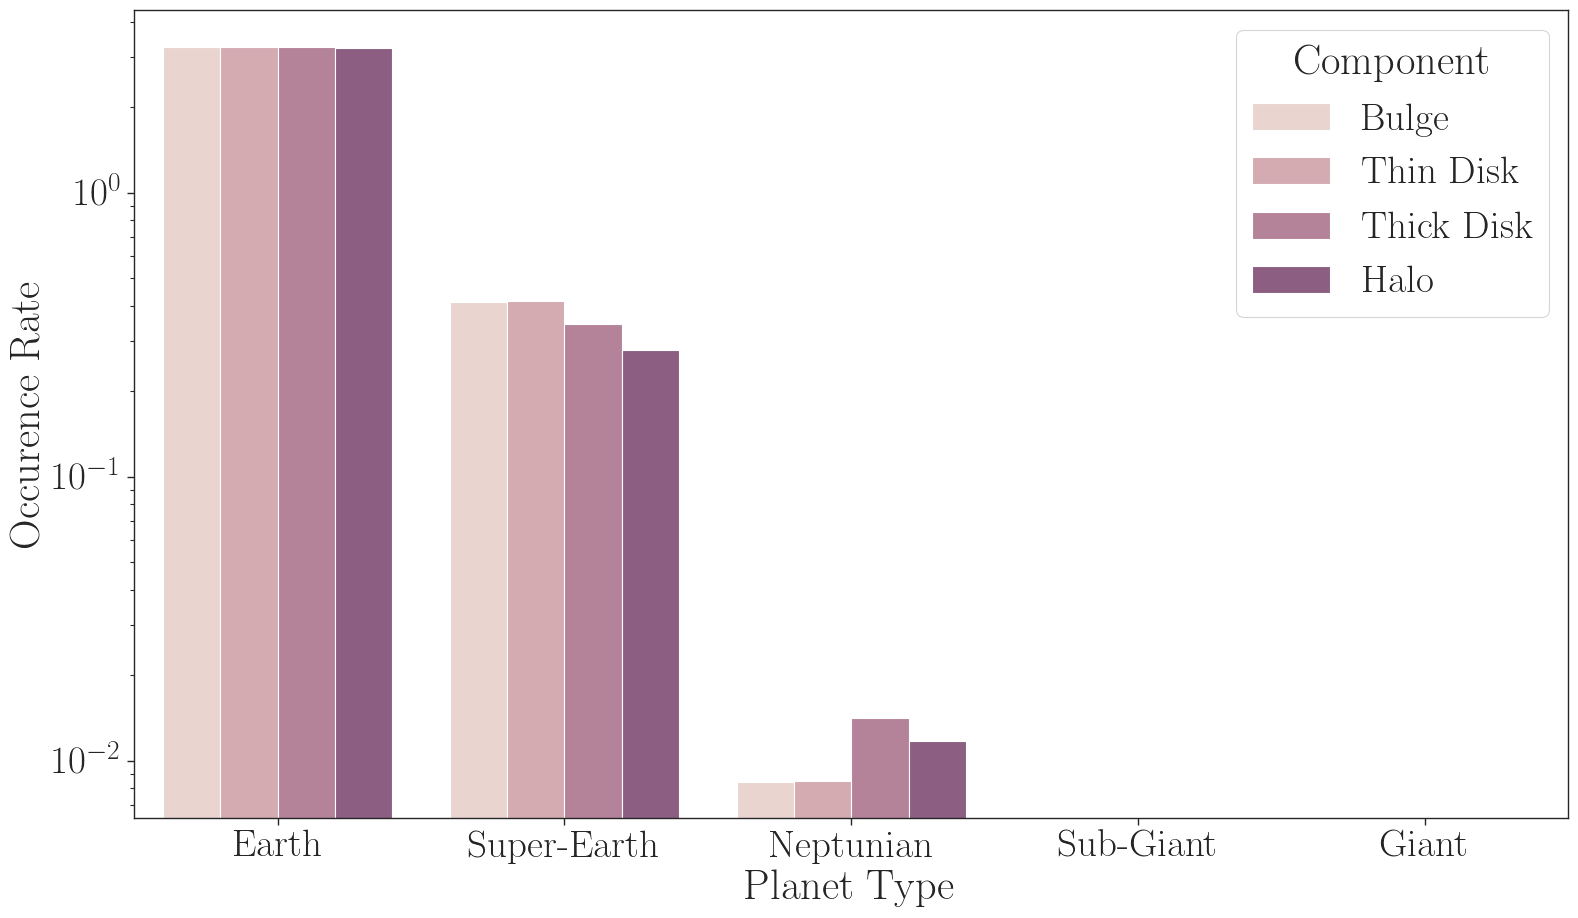

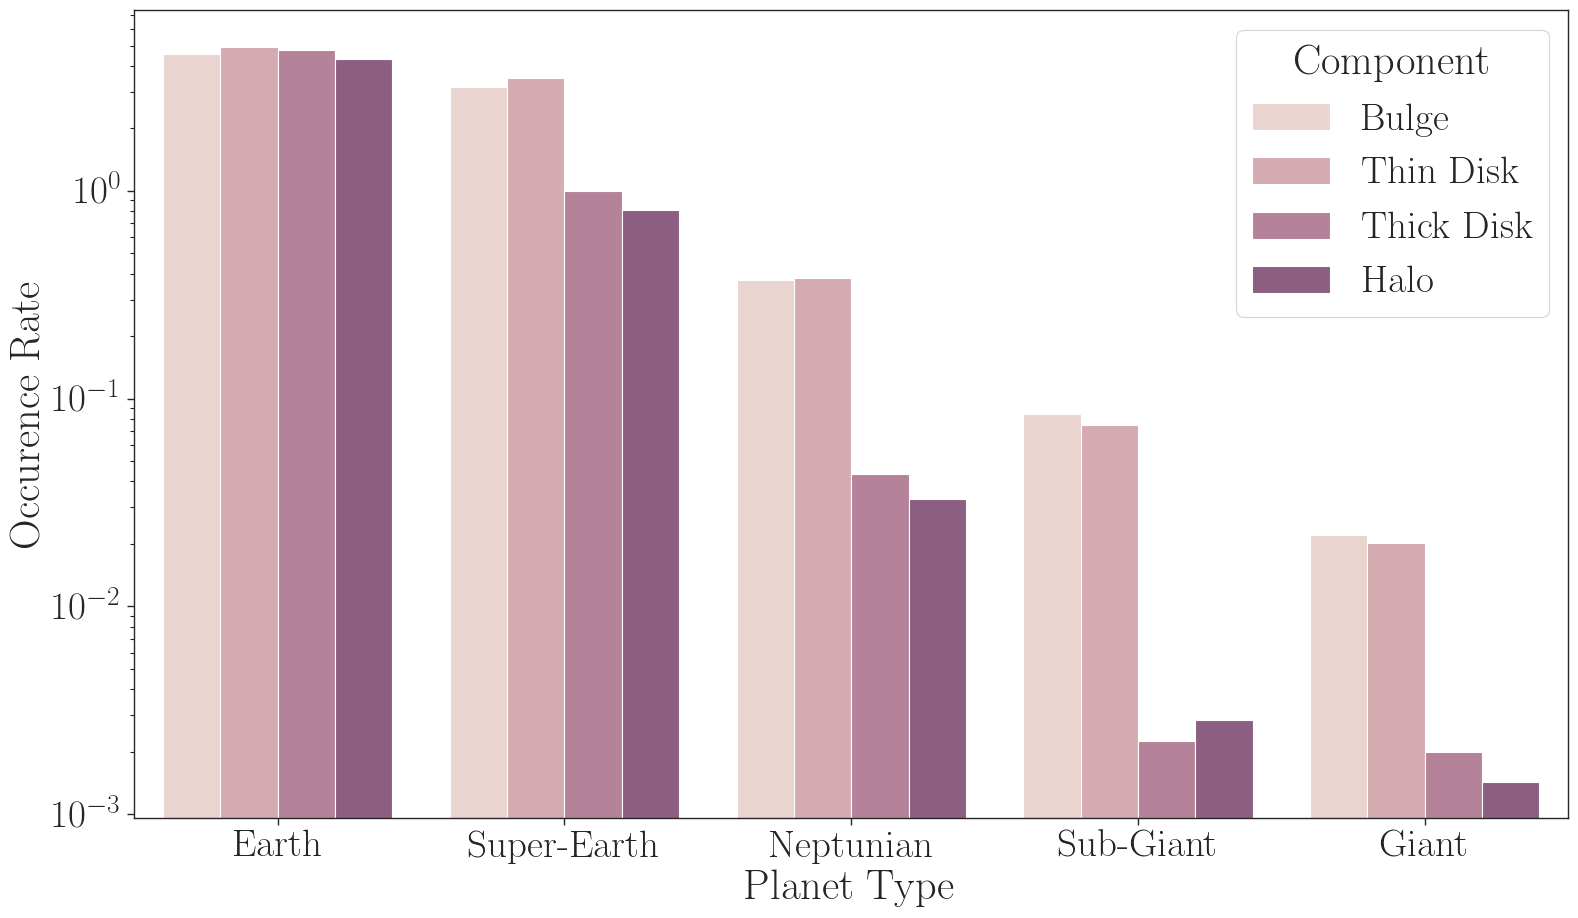

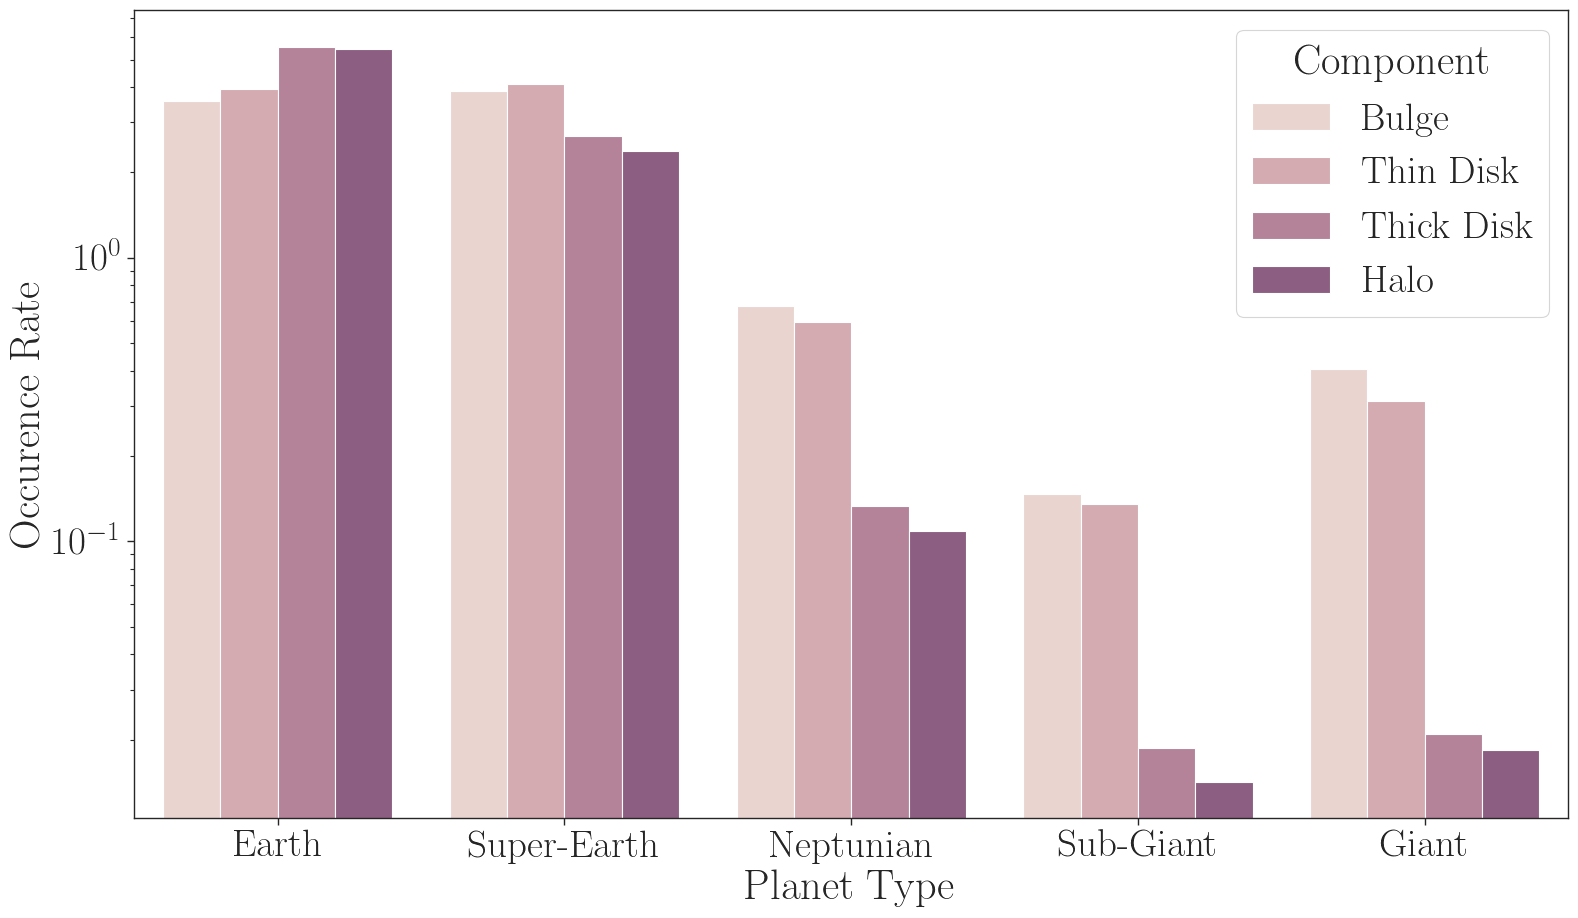

In [ ]:
def barplot(occurence_rate_long_format, host_star_mass):
    plt.figure()
    with sns.axes_style("ticks"):
        occurence_rate_barplot = sns.barplot(
            data=occurence_rate_long_format,
            x="Planet Type",
            y="Occurence Rate",
            hue="Component",
            hue_order=["Bulge", "Thin Disk", "Thick Disk", "Halo"],
            log=True,
            palette=get_palette(),
        )

    FigureProcessor(occurence_rate_barplot.figure).save(
        f"occurence_rates_with_host_star_mass_={host_star_mass}.pdf",
        sub_directory=figure_subdirectory,
        save=save,
    )
    return occurence_rate_barplot


for m in masses:
    plot = barplot(occurence_rate_long_format[m], host_star_mass=m)